In [1]:
import torch
from torch import nn
from torch import optim
from torch import functional as F
import torch.utils.data
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce

In [2]:
class UNetEncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=(4,4), stride=(2,2), padding=1, batch_norm=True, relu_slope=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride, bias=not batch_norm)
        self.conv.weight.data.normal_(0, 0.02)
        self.bn = None
        if batch_norm:
            self.bn = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(relu_slope, inplace=True)
    
    def forward(self, X):
        out = self.conv(X)
        if self.bn:
            out = self.bn(out)
        out = self.leaky_relu(out)
        return out

class UNetDecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=(4,4), stride=(2,2), padding=1, dropout=None):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel, padding=padding, stride=stride, bias=False)
        self.conv.weight.data.normal_(0, 0.02)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = None
        
        if dropout:
            self.dropout = nn.Dropout2d(dropout, inplace=True)
            
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        out = self.conv(X)
        out = self.bn(out)
        if self.dropout:
            out = self.dropout(out)
        out = self.relu(out)
            
        return out
    

In [3]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.encoder = nn.ModuleList([
            UNetEncoderBlock(in_channels, 64, batch_norm=False, relu_slope=0.2),
            UNetEncoderBlock(64, 128, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(128, 256, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(256, 512, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(512, 512, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(512, 512, batch_norm=True, relu_slope=0.2),
            UNetEncoderBlock(512, 512, batch_norm=False, relu_slope=0.2),
            UNetEncoderBlock(512, 512, batch_norm=False, relu_slope=0.2)
        ])
        
        self.decoder = nn.ModuleList([
            UNetDecoderBlock(512, 512, dropout=0.5),
            UNetDecoderBlock(1024, 512, dropout=0.5),
            UNetDecoderBlock(1024, 512, dropout=0.5),
            UNetDecoderBlock(1024, 512),
            UNetDecoderBlock(1024, 256),
            UNetDecoderBlock(512, 128),
            UNetDecoderBlock(256, 64),
            UNetDecoderBlock(128, out_channels),
        ])
        
        self.final = nn.Sequential(nn.Tanh())
        
    def forward(self, X):
        activations = []
        out = X
        # roll the input throught the encoder branch, storing the activations
        for l in self.encoder:
            out = l(out)
            activations.insert(0, out)
        
        out =  self.decoder[0](out)
        
        # execute decoder branch concatenating corresponding encoder activations
        for act, l in zip(activations[1:], self.decoder[1:]):
            out = l(torch.cat([act, out], dim=1))
        
        out = self.final(out)
        return out

# just for syntax sugar
class Generator(UNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

In [4]:
class Discriminator(nn.Sequential):
    _patch_sizes = {
        1: [64, 128],
        16: [64, 128],
        70: [64, 128, 256, 512],
        286: [64, 128, 256, 512, 512, 512]
    }
    
    def requires_grad(self, value):
        for p in self.parameters():
            p.requires_grad = value
    
    def __init__(self, patch_size=70, in_channels=3):
        super().__init__()
        if patch_size not in Discriminator._patch_sizes:
            raise Exception("unkown patch_size, should be one of", list(Discriminator._patch_sizes.keys()))
        
        kernel_size, stride = (4,4), (2,2)
        if patch_size == 1:
            kernel_size = stride = (1,1)
        channels = Discriminator._patch_sizes[patch_size]
        
        layers = [UNetEncoderBlock(in_channels, channels[0], batch_norm=False, relu_slope=0.2)]
        for i, (in_ch, out_ch) in enumerate(zip(channels[:-1], channels[1:])):
            layers.append(UNetEncoderBlock(in_ch, out_ch, batch_norm=i > 0, relu_slope=0.2, kernel=kernel_size, stride=stride))
        
        conv = nn.Conv2d(channels[-1], 1, kernel_size=kernel_size, stride=stride)
        conv.weight.data.normal_(0, 0.02)
        layers.append(conv)
        
        for i, l in enumerate(layers): self.add_module(str(i), l)

In [5]:
batch = np.random.normal(0, 1, (1, 3, 256, 256))
gen = Generator(out_channels=3)
dis = Discriminator(70, in_channels=3+3)
o = gen(torch.from_numpy(batch).float())
dis(torch.cat([o, o], dim=1))
gen = Generator(out_channels=3)
dis = Discriminator(70, in_channels=3+3)
Gcriterion = optim.Adam(gen.parameters(), lr=0.0002, betas=[0.5, 0.999])
Dcriterion = optim.Adam(dis.parameters(), lr=0.0002, betas=[0.5, 0.999])
bce_loss = nn.BCEWithLogitsLoss()
l1_loss = nn.L1Loss()

In [6]:
def loss_gen(X, fake_y, real_y):
    x_fake_y = torch.cat([X, fake_y], dim=1)
    
    pred = dis(x_fake_y)
    target = torch.ones_like(pred)
    loss_fake = bce_loss(pred, target)
    
    l1 = l1_loss(fake_y, real_y)*100
    return loss_fake + l1
    

def loss_dis(X, fake_y, real_y):
    x_fake_y = torch.cat([X, fake_y.detach()], dim=1)
    x_real_y = torch.cat([X, real_y], dim=1)
    
    pred = dis(x_fake_y)
    target = torch.zeros_like(pred)
    loss_fake = bce_loss(pred, target)
    
    pred = dis(x_real_y)
    target = torch.ones_like(pred)
    loss_real = bce_loss(pred, target)
    

    return (loss_fake + loss_real) * 0.5

In [7]:
import cv2

# img = cv2.imread('facades/test/1.jpg')
# cv2.imshow("READ IMG", img)
# cv2.waitKey(0)

def read_image(path):
    full_img = cv2.imread(path)
    y,x = full_img[:,:256,::-1], full_img[:,256:,::-1]
    return x,y

x,y = read_image("facades/train/10.jpg")

In [8]:
train_filenames = glob("facades/train/**")
test_filenames = glob("facades/test/**")
valid_filenames = glob("facades/val/**")

In [9]:
len(train_filenames), len(test_filenames), len(valid_filenames)

(400, 106, 100)

In [10]:
def filenames2bytes(filenames):
    datas = [read_image(f) for f in filenames]
    x = [a for a,_ in datas]
    y = [b for _,b in datas]
    return np.array(x), np.array(y)
x_train,y_train = filenames2bytes(train_filenames)
x_means,x_stds = x_train.mean(axis=(0,1,2)), x_train.std(axis=(0,1,2))
x_train = (x_train-x_means)/x_stds
y_means,y_stds = y_train.mean(axis=(0,1,2)), y_train.std(axis=(0,1,2))
y_train = (y_train-y_means)/y_stds


x_test,y_test = filenames2bytes(test_filenames)
x_test = (x_test-x_means)/x_stds
y_test = (y_test-y_means)/y_stds

x_valid,y_valid = filenames2bytes(valid_filenames)
x_valid = (x_valid-x_means)/x_stds
y_valid = (y_valid-y_means)/y_stds

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, idx):
        return self.x[idx].transpose(2, 0, 1), self.y[idx].transpose(2, 0, 1)
    
    def __len__(self): return len(self.x)
    
train_ds = Dataset(x_train, y_train)
test_ds = Dataset(x_test, y_test)
valid_ds = Dataset(x_valid, y_valid)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=32, shuffle=False)

In [12]:
gen = Generator(out_channels=3)

In [13]:
dis = Discriminator(70, in_channels=3+3)

In [14]:
Gcriterion = optim.Adam(gen.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [15]:
Dcriterion = optim.Adam(dis.parameters(), lr=0.0002, betas=[0.5, 0.999])

In [16]:
# def load_models_data():
#   state_data = torch.load("/content/drive/My Drive/pix2pix/20191024_144527_pix2pix.pt")
#   gen.load_state_dict(state_data["gen_state_dict"])
#   Gcriterion.load_state_dict(state_data["gen_optim"])
#   dis.load_state_dict(state_data["dis_state_dict"])
#   Dcriterion.load_state_dict(state_data["dis_optim"])
# load_models_data()

In [19]:
nums, losses = [], []
for j in range(1):
  print("starting epoch", j)
  for i, (x_batch, y_batch) in enumerate(train_dl):
      x_batch = x_batch.float()
      y_batch = y_batch.float()
      
      fake_y = gen(x_batch)
      dis.requires_grad(True)
      Dcriterion.zero_grad()
      l = loss_dis(x_batch, fake_y, y_batch)
      # print("dis", l)
      l.backward()
      Dcriterion.step()
      
      Gcriterion.zero_grad()
      dis.requires_grad(False)
      l = loss_gen(x_batch, fake_y, y_batch)
      # print("gen", l)
      l.backward()
      Gcriterion.step()
      
      # if i >= 10: break
  print("finished epoch", j)

from datetime import datetime
now = datetime.now()
name = now.strftime("%Y%m%d_%H%M%S_pix2pix.pt")
torch.save({
    "gen_state_dict": gen.state_dict(),
    "dis_state_dict": dis.state_dict(),
    "gen_optim": Gcriterion.state_dict(),
    "dis_optim": Dcriterion.state_dict()
}, "pix2pix/%s" % str(name))

starting epoch 0
finished epoch 0


In [23]:
x,y = test_ds[10]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


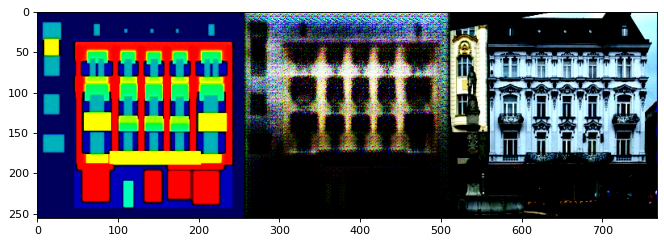

In [24]:
plt.figure(figsize=(10,4), dpi=80)
fake_im_t = gen(torch.from_numpy(x.reshape(-1, 3, 256, 256)).float()).detach()
fake_im = fake_im_t.cpu().numpy()[0]
plt.imshow(np.concatenate([x.transpose(1, 2, 0), fake_im.transpose(1, 2, 0), y.transpose(1, 2, 0), ], axis=1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


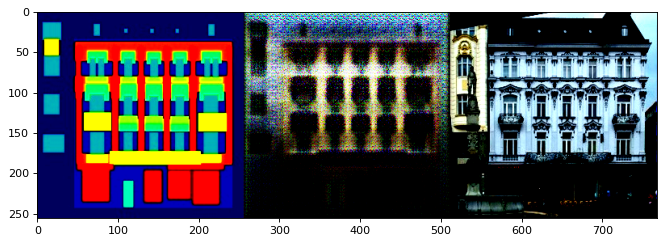

In [32]:
plt.figure(figsize=(10,4), dpi=80)
fake_im_t = gen(torch.from_numpy(x.reshape(-1, 3, 256, 256)).float()).detach()
fake_im = fake_im_t.cpu().numpy()[0]
plt.imshow(np.concatenate([x.transpose(1, 2, 0), fake_im.transpose(1, 2, 0), y.transpose(1, 2, 0)], axis=1))


In [ ]:
x_t = torch.from_numpy(x[None,...]).float().cuda()
y_t = torch.from_numpy(y[None,...]).float().cuda()
torch.sigmoid(dis(torch.cat([x_t, fake_im_t], dim=1)))
# torch.sigmoid(dis(torch.cat([x_t, y_t], dim=1)))